# Introduction


[Crossy Road](https://www.crossyroad.com/) is an arcade video game built around the age-old joke "Why did the chicken cross the road?" In the game, the chicken (controlled by the player) has to cross the road without getting hit by vehicles.

We want to develop a reinforcement learning (RL) game agent capable of playing Crossy Road. The game’s endless and random nature makes it a great candidate for RL.

The agent will learn to maximize its score by getting the chicken to cross the road and avoid obstacles in its path, with the ultimate goal of crossing the road as many times as possible without collisions. Once the agent is capable of successfully getting the chicken to cross the road and reach the goal position, another goal could be to minimize the time it takes for the chicken to cross the road.


# Configuration


We'll start by importing the [Python](https://www.python.org/) libraries necessary for this project and configuring some things.


In [22]:
import cv2
import gymnasium as gym
from gymnasium.wrappers import TimeLimit

try:
    from google.colab.patches import cv2_imshow
except ImportError:
    # code taken from: https://github.com/googlecolab/colabtools/blob/main/google/colab/patches/__init__.py
    import PIL.Image
    from IPython import display

    def cv2_imshow(a):
        """A replacement for cv2.imshow() for use in Jupyter notebooks.

        Args:
            a: np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. For
            example, a shape of (N, M, 3) is an NxM BGR color image, and a shape of
            (N, M, 4) is an NxM BGRA color image.
        """
        a = a.clip(0, 255).astype("uint8")
        # cv2 stores colors as BGR; convert to RGB
        if a.ndim == 3:
            if a.shape[2] == 4:
                a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
            else:
                a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
        display.display(PIL.Image.fromarray(a))

# Crossy Road Environment


Our first step is to implement a Crossy Road environment, which will encapsulate our representation of the reinforcement learning problem that the game poses.

For this, we will utilize the [Gymnasium](https://gymnasium.farama.org/) library (a fork of the [OpenAI Gym](https://openai.com/research/openai-gym-beta) library), which provides a standard API for RL and various reference environments.

Specifically, we will use the [Freeway](https://gymnasium.farama.org/environments/atari/freeway/) environment, which models an [Atari](https://atari.com/) game that closely resembles Crossy Road. This gives us a Pythonic interface to work with, which we can later use to develop RL models and create an agent that can play Crossy Road successfully.


## Initializing the Environment


We will start off by initializing the environment using Gymnasium.

We pass in the following arguments (documented [here](https://gymnasium.farama.org/environments/atari/)) to specify the environment:

**Environment Flavor:**

The environment `id`, `mode`, and `difficulty` combine to specify the specific flavor of the environment:

- `id="ALE/Freeway-v5"`: simulates the Atari game Freeway via the [Arcade Learning Environment (ALE)](https://github.com/Farama-Foundation/Arcade-Learning-Environment) through the [Stella](https://stella-emu.github.io/) emulator
- `mode=0`: selects [Game 1 (Lake Shore Drive, Chicago, 3 A.M.)](https://atariage.com/manual_html_page.php?SoftwareLabelID=192) as the map to use
- `difficulty=0`: selects the default difficulty setting

**Stochasticity:**

As stated in the documentation:

> As the Atari games are entirely deterministic, agents can achieve state-of-the-art performance by simply memorizing an optimal sequence of actions while completely ignoring observations from the environment.

To combat this, we use `frameskip` and `repeat_action_probability`:

- `frameskip=4`: enables frame skipping (sets the number of frames to skip on each skip to $4$)
- `repeat_action_probability=0.25`: enables sticky actions (sets the probability of repeating the previous action instead of executing the current action to $25\%$)

**Simulation:**

The parameters `full_action_space` and `render_mode` are used to specify how the environment is simulated:

- `full_action_space=False`: limits the action space to the $3$ legal actions we will actually use instead of all $18$ possible actions that can be performed on an Atari 2600 console
- `render_mode="rgb_array"`: specifies that the game should be rendered as an RGB frame


In [23]:
env = gym.make(
    id="ALE/Freeway-v5",
    mode=0,
    difficulty=0,
    obs_type="rgb",
    frameskip=4,
    repeat_action_probability=0.25,
    full_action_space=False,
    render_mode="rgb_array",
)

We will also modify the metadata to set `render_fps` to $30$, meaning the game will run at $30$ frames per second.

In [24]:
env.metadata["render_fps"] = 30

Now, we are ready to learn a little more about how out environment is implemented.


## Observations


Let's start with the observation space.


In [25]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

This observation space represents the RGB image that is displayed to a human player.


## Actions


Next, let's move on to the action space.


In [26]:
env.action_space

Discrete(3)

This action space represents the actions that the chicken can take in each step:


In [27]:
action_meaning = {
    0: "NOOP",
    1: "UP",
    2: "DOWN",
}
print(action_meaning)

{0: 'NOOP', 1: 'UP', 2: 'DOWN'}


## Rewards


Finally, let's move on to the reward range.


In [28]:
env.reward_range

(-inf, inf)

We can see that the reward range is $(-\infty, \infty)$. However, this is not very informative.

As the documentation tells us:

> You receive a point for every chicken that makes it to the top of the screen after crossing all the lanes of traffic.


In [29]:
# TODO: add a wrapper to use a different reward function

# Agent-Environment Interaction


Our next step is to create a mechanism by which an agent can interact with the environment.


First, let's create a `log_step()` function that logs information about a certain time step.

In [30]:
def log_step(step, action, observation, reward, terminated, truncated, info):
    print(f"\n***** Step {step} *****\n")
    if action is not None:
        print(f"Action: {action} ({action_meaning[action]})")
    if observation is not None:
        print("Observation:", observation)
    if reward is not None:
        print("Reward:", reward)
    if terminated is not None:
        print("Terminated:", terminated)
    if truncated is not None:
        print("Truncated:", truncated)
    if info is not None:
        print("Info:", info)

Now, let's create a `simulate()` function that takes in an environment, agent, and number of episodes.

It simulates running `num_episodes` episodes in the environment `env`, where the player's actions are defined by the behavior of `agent`.

In [31]:
def simulate(env: gym.Env, agent: any, num_episodes: int):
    for episode in range(1, num_episodes + 1):
        print(f"########## Episode {episode} ##########")
        step = 0
        action = None
        observation, info = env.reset()
        reward, terminated, truncated = 0.0, False, False
        log_step(step, action, None, reward, terminated, truncated, info)
        view = env.render()
        cv2_imshow(view)
        while not (terminated or truncated):
            step += 1
            action = agent.sample_action(observation)
            observation, reward, terminated, truncated, info = env.step(action)
            log_step(step, action, None, reward, terminated, truncated, info)
            view = env.render()
            cv2_imshow(view)

# Random Agent


In [32]:
class RandomAgent:
    def __init__(self, env):
        self.env = env

    def sample_action(self, observation):
        return self.env.action_space.sample()

########## Episode 1 ##########

***** Step 0 *****

Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 0, 'frame_number': 0}


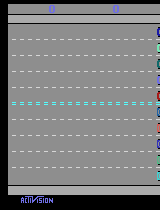


***** Step 1 *****

Action: 0 (NOOP)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 4, 'frame_number': 4}


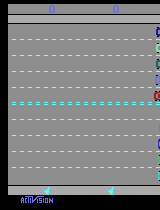


***** Step 2 *****

Action: 0 (NOOP)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 8, 'frame_number': 8}


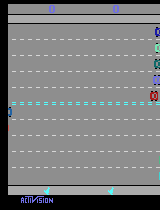


***** Step 3 *****

Action: 2 (DOWN)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 12, 'frame_number': 12}


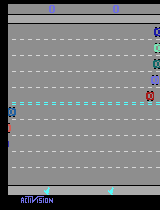


***** Step 4 *****

Action: 0 (NOOP)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 16, 'frame_number': 16}


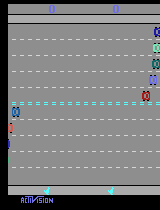


***** Step 5 *****

Action: 1 (UP)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 20, 'frame_number': 20}


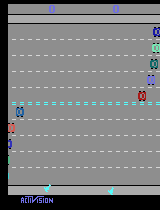


***** Step 6 *****

Action: 1 (UP)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 24, 'frame_number': 24}


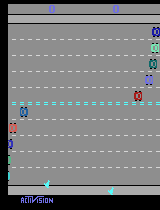


***** Step 7 *****

Action: 0 (NOOP)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 28, 'frame_number': 28}


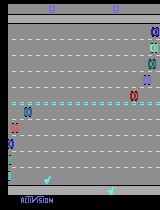


***** Step 8 *****

Action: 0 (NOOP)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 32, 'frame_number': 32}


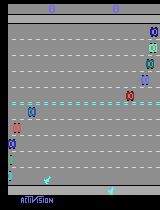


***** Step 9 *****

Action: 2 (DOWN)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 36, 'frame_number': 36}


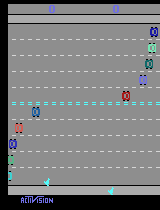


***** Step 10 *****

Action: 1 (UP)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 40, 'frame_number': 40}


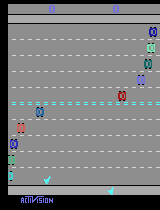


***** Step 11 *****

Action: 0 (NOOP)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 44, 'frame_number': 44}


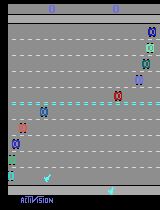


***** Step 12 *****

Action: 2 (DOWN)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 48, 'frame_number': 48}


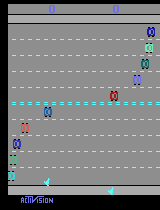


***** Step 13 *****

Action: 0 (NOOP)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 52, 'frame_number': 52}


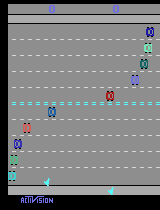


***** Step 14 *****

Action: 2 (DOWN)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 56, 'frame_number': 56}


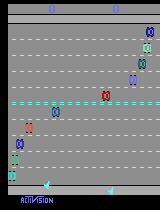


***** Step 15 *****

Action: 1 (UP)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 60, 'frame_number': 60}


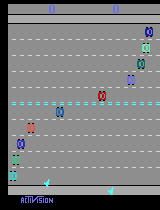


***** Step 16 *****

Action: 2 (DOWN)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 64, 'frame_number': 64}


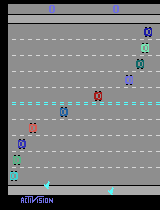


***** Step 17 *****

Action: 1 (UP)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 68, 'frame_number': 68}


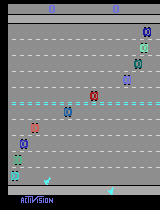


***** Step 18 *****

Action: 2 (DOWN)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 72, 'frame_number': 72}


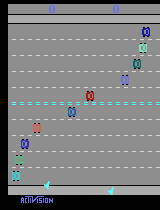


***** Step 19 *****

Action: 1 (UP)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 76, 'frame_number': 76}


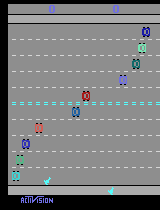


***** Step 20 *****

Action: 1 (UP)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 80, 'frame_number': 80}


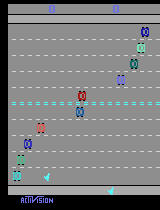


***** Step 21 *****

Action: 1 (UP)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 84, 'frame_number': 84}


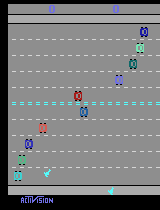


***** Step 22 *****

Action: 1 (UP)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 88, 'frame_number': 88}


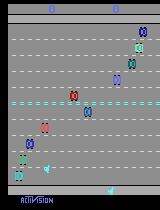


***** Step 23 *****

Action: 0 (NOOP)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 92, 'frame_number': 92}


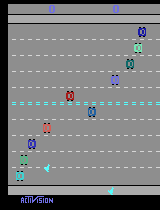


***** Step 24 *****

Action: 2 (DOWN)
Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 96, 'frame_number': 96}


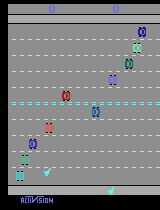


***** Step 25 *****

Action: 1 (UP)
Reward: 0.0
Terminated: False
Truncated: True
Info: {'lives': 0, 'episode_frame_number': 100, 'frame_number': 100}


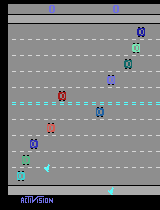

In [33]:
time_limited_env = TimeLimit(env, max_episode_steps=25)
random_agent = RandomAgent(time_limited_env)
simulate(time_limited_env, random_agent, 1)

In [34]:
# from gymnasium.utils.play import play

# play(env, keys_to_action={"w": 1, "s": 2}, zoom=3.0)

# Reinforcement Learning Agent


# Conclusion
